# Classificazione video con metodi tradizionali

In questo notebook viene presentata la classificazione dei video utilizzando metodi tradizionali, in particolare il classificatore DTW (Dynamic Time Warping) e le feature HOG (Histogram of Oriented Gradients) e LBP (Local Binary Patterns).

## Import delle librerie

In [1]:
from handcrafted.app.dataset.dataset import Dataset
from handcrafted.app.model.dtw_classifier import DTWClassifier
from handcrafted.app.model.model_statistics import ModelStatistics

import matplotlib.pyplot as plt

## Import del dataset

Sfruttando la classe [Dataset](./handcrafted/app/dataset/dataset.py), vengono caricati, dal file [WLASL_v0.3.json](./data/WLASL_v0.3.json), tutti i video presenti nel dataset.

In [2]:
dataset = Dataset("data/WLASL_v0.3.json")

## Creazione del classificatore

All'interno dell'oggetto [DTWClassifier](./handcrafted/app/model/dtw_classifier.py), creato passando il dataset e le label di esso come parametri, vengono definiti i metodi per la classificazione dei video.

In [3]:
dtw_classifier = DTWClassifier(dataset, dataset.glosses)

## Suddivisione del dataset in training e test set

La suddivisione dei dati segue la struttura definita nel file [WLASL_v0.3.json](./data/WLASL_v0.3.json).
Al training set vengono aggiunti anche i video di validation, siccome il classificatore DTW non necessita di un validation set e i video disponibili per ogni parola sono pochi.
In questo caso vengono analizzati tutti i video corrispondenti alle prime 5 parole.

In [4]:
dtw_classifier.train_test_videos(num_glosses=5)

Train videos: 52, Test videos: 5


## Calcolo delle distanze tra i video del test set e quelli del training set

Le feature HOG e LBP vengono estratte dai video e utilizzate per calcolare la similarità tra i video del test set e quelli del training set.
Tramite test empirici è stato verificato che l'utilizzo di queste feature permette di ottenere risultati migliori.

Il metodo `compute_dtw_similarity_matrix` calcola la matrice di similarità del test set, le label associate al training e le label reali del test set.
La matrice di similarità è calcolata andando a confrontare ogni video del test set con tutti i video del training set.
Viene quindi effettuato un confronto per ogni coppia di video, ottenendo le features per ciascuna e, dopo averle concatenate, vengono passate alla funzione `dtw_kernel` che calcola la distanza DTW tra le sequenze.
Questo valore di distanza viene poi normalizzato e trasformato in similarità.
Viene infine richiamato il metodo `dtw_predict` sulla matrice `X_test` e `y_train` per classificare i video di test associandoli alla label che ha similarità più alta.

In [5]:
X_test, y_train, y_test = dtw_classifier.compute_dtw_similarity_matrix()
y_pred = dtw_classifier.dtw_predict(X_test, y_train)

Processing video: 1/260
Processing video pair: data/videos/17713.mp4 and data/videos/69241.mp4
len 1st: 90, 2nd: 74
Caricamento da file: data/hf/17713/hog_features
hog_features shape: (90, 26244)
Caricamento da file: data/hf/17713/lbp_features
lbp_features shape: (90, 26)
Caricamento da file: data/hf/69241/hog_features
hog_features shape: (74, 26244)
Caricamento da file: data/hf/69241/lbp_features
lbp_features shape: (74, 26)
Similarity: 0.3678807074542615
Processing video: 2/260
Processing video pair: data/videos/17713.mp4 and data/videos/07069.mp4
len 1st: 90, 2nd: 29
Caricamento da file: data/hf/17713/hog_features
hog_features shape: (90, 26244)
Caricamento da file: data/hf/17713/lbp_features
lbp_features shape: (90, 26)
Caricamento da file: data/hf/07069/hog_features
hog_features shape: (29, 26244)
Caricamento da file: data/hf/07069/lbp_features
lbp_features shape: (29, 26)
Similarity: 0.36788071105213205
Processing video: 3/260
Processing video pair: data/videos/17713.mp4 and data

## Stampa dei risultati

Siccome `y_test` e `y_pred` utilizzano gli indici della label a cui fanno riferimento invece che la parola sotto forma di testo, di seguito vengono estratti i glosses relativi agli indici in modo tale da rendere più leggibili e facili da analizzare i risultati.

In [6]:
y_test_labels = [dataset.glosses[y] for y in y_test]
y_pred_labels = [dataset.glosses[y] for y in y_pred]

Tramite la classe [ModelStatistics](./handcrafted/app/model/model_statistics.py) si effettua la stampa dei risultati.

In [7]:
model_stats = ModelStatistics(save_name="confusion_matrix_trad")
model_stats.print_classification_report(y_test_labels, y_pred_labels)
model_stats.print_accuracy(y_test_labels, y_pred_labels)

Classification Report:
               precision    recall  f1-score   support

      before       1.00      0.33      0.50         3
       chair       0.00      1.00      0.00         0
    computer       0.00      0.00      1.00         1
       drink       0.50      1.00      0.67         1

    accuracy                           0.40         5
   macro avg       0.38      0.58      0.54         5
weighted avg       0.70      0.40      0.63         5

Accuracy: 40.00%


## Stampa della confusion matrix

Viene inoltre mostrata la confusion matrix che permette di analizzare molto chiaramente i risultati ottenuti.

Confusion matrix saved at plots/confusion_matrix_trad.png


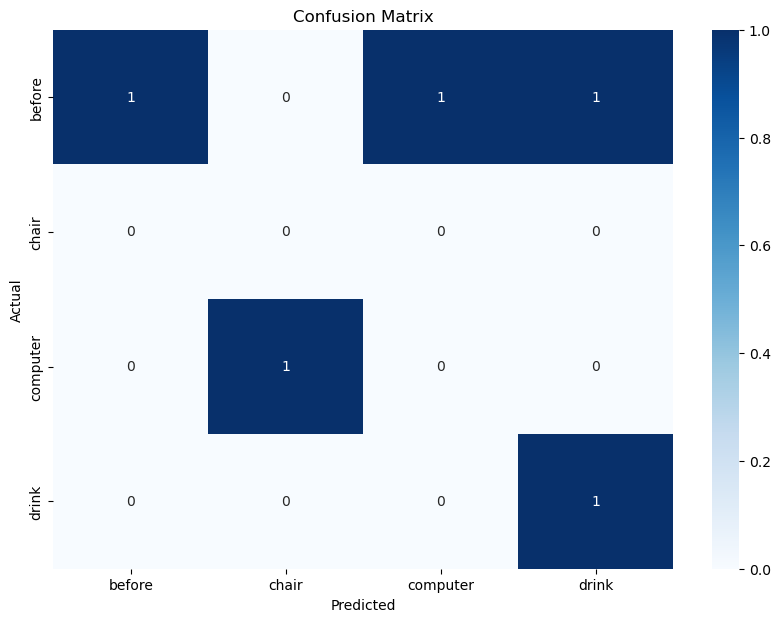

In [8]:
model_stats.plot_confusion_matrix(y_test_labels, y_pred_labels)

## Stampa dell'istogramma dei risultati
L'istogramma mostra la similarità tra i video classificati correttamente e quelli classificati in modo errato.
Si può notare come i valori di similarità tra video classificati correttamente e in maniera errata siano molto vicini, questo è dovuto al fatto che le feature estratte dai video (hog, lbp) sono molto complesse e non permettono di catturare le differenze tra i vari movimenti dei soggetti.

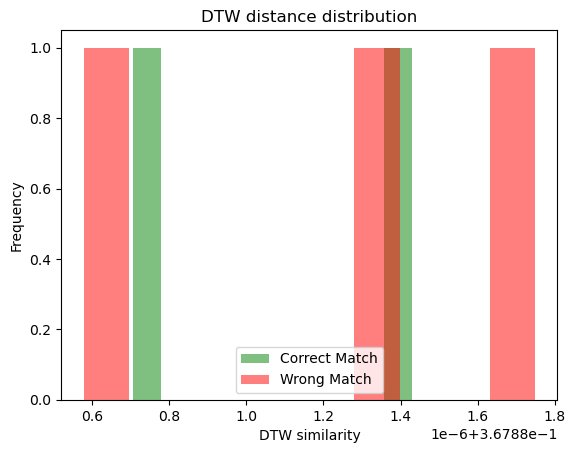

In [9]:
dtw_correct = [
    X_test[i][0] for i in range(len(X_test)) if y_test[i] == y_pred[i]
]
dtw_wrong = [
    X_test[i][0] for i in range(len(X_test)) if y_test[i] != y_pred[i]
]

plt.hist(dtw_correct, bins=10, alpha=0.5, label="Correct Match", color="green")
plt.hist(dtw_wrong, bins=10, alpha=0.5, label="Wrong Match", color="red")
plt.xlabel("DTW similarity")
plt.ylabel("Frequency")
plt.legend()
plt.title("DTW distance distribution")
plt.show()